In [2]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt
from scipy.stats import random_correlation
from sklearn.datasets import make_sparse_spd_matrix

Using TensorFlow backend.


In [27]:
## Generalisation to multiple stocks -- SET D= # of stocks
N=30 # time disrectization
D = 3#number of stocks
S0 = np.random.normal(1,0.1,D).reshape(1,D) # initial value of the asset(s)
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
sigma = np.abs(np.random.normal(0.2,0.1,D).reshape(D,))
mu=np.random.normal(0.1,0.1,D).reshape(1,D)
r=0.0
gamma=0.0
R=10**5 # number of Trajectories
eigenvals = []
for _ in range(D):
    eigenvals.append(np.random.uniform(0,D))
eigenvals = D/sum(eigenvals)*np.array(eigenvals)
rho = random_correlation.rvs(eigenvals)
# logS= np.zeros((N,R))
# logS[0,]=np.log(S0)*np.ones((1,R))

# for i in range(R):
#     for j in range(N-1):
#         increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
#         logS[j+1,i] =logS[j,i]+increment

# S=np.exp(logS)

In [29]:
rho

array([[ 1.        ,  0.43104348, -0.93662773],
       [ 0.43104348,  1.        , -0.6265213 ],
       [-0.93662773, -0.6265213 ,  1.        ]])

In [8]:
#Definition of neural networks for trading strategies

m = D # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [ ]:
# Implementing the outcoming of trading via neural networks
# Inputs is the training set below, containing the price S0, 
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
trade = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))

inputs = [price]+[trade]+[tradeeval]+[wealth]
outputhelper=[]
N=1
for j in range(N):
    strategy = price
    strategyeval=tradeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j 
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew
    logwealth= Lambda(lambda x : K.log(x))(wealth)  
    logwealth= Lambda(lambda x : x+r*T/N)(logwealth)
    helper1 = Multiply()([strategy, incr])
    helper1 = Lambda(lambda x : K.sum(x,axis=1))(helper1)
    logwealth = Add()([logwealth, helper1])
    helper2 = Multiply()([strategy, strategy])   
    #helper2 = Lambda(lambda x : K.sum(x,axis=1))(helper2)
    helper2 = Lambda(lambda x: x*sigma**2/2*T/N)(helper2)
    #helper3 = Lambda(lambda x : x*sigma**2/2*T/N)(helper2)
    helper3 = Lambda(lambda x: K.sum(x,axis=1))(helper2)
    logwealth = Subtract()([logwealth, helper3])
    helper4 = Lambda(lambda x : x*r*T/N)(strategy)
    helper4 = Lambda(lambda x: K.sum(x,axis=1))(helper4)
    logwealth = Subtract()([logwealth, helper4])
    #Add correlation terms
    
    for i in range(m):
        strat_i = Lambda(lambda x: K.slice(x,[0,i],[0,1]))(strategy) + 0*strategy
        strat_i = Lambda(lambda x: K.sum(x,axis=1))(strat_i)
        #print(K.int_shape(strat_i))
        for j in range(i+1,m):
            strat_j = Lambda(lambda x: K.slice(x,[0,j],[0,1]))(strategy) + 0*strategy
            strat_j = Lambda(lambda x: K.sum(x,axis=1))(strat_j)
            #print(strat_j)
            helper5 = Lambda(lambda x: x*sigma[i]*sigma[j]*rho[i][j]*T/N)(strat_i)        
            helper5 = Multiply() ([helper5,strat_j])
            print(K.int_shape(helper5))
            print(K.int_shape(logwealth))
            logwealth = Subtract()([logwealth, helper5])
            
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval] # here we collect the strategies
    wealth=wealthnew
outputs = wealth
#randomendowment = Lambda(lambda x : -0.0*(K.abs(x-1.0)+x-1.0))(price) 
#outputs = Add()([wealth,randomendowment])
outputs = [outputs] + outputhelper 
#print(K.int_shape(outputhelper[0]))
outputs = Concatenate()(outputs)

model_MertonD = Model(inputs=inputs, outputs=outputs)

In [30]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0

#Generate correlated price processes

from scipy.linalg import cholesky
U= cholesky(rho)
uncorr = [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]
corr = []
for unc in uncorr:
    corr.append(unc@U)

# xtrain consists of the price S0, 
#the initial hedging being 0, and dummy variables hedgeeval where the strategies are evaluated, 
#the initial wealth and the increments of the log price process     

xtrain = ([np.ones((Ktrain,1))@initialprice] +
          [np.zeros((Ktrain,m))]+
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,1))] + corr)
          #[np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

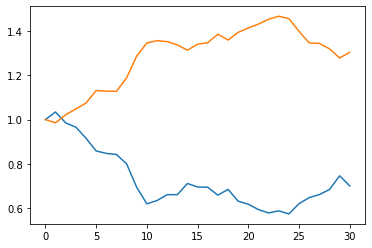

In [31]:
s1 = [1]
s2 = [1]
s3 =[1]
for i in range(N):
    s1.append(s1[i]+corr[i][0,0])
    s2.append(s2[i]+corr[i][0,1])
    s3.append(s3[i]+corr[i][0,2])
plt.plot(range(N+1),s1,s3)
#plt.plot(range(N+1),s3)
plt.show()

In [29]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])#-((y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z

In [30]:
from keras import optimizers

adam=optimizers.Adam(lr=0.01)

model_MertonD.compile(optimizer='adam',loss=custom_loss)

In [31]:
import matplotlib.pyplot as plt

for i in range(1):
    model_MertonD.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
100000/100000 [==============================] - 31s 314us/step - loss: -0.5644
Epoch 2/10
100000/100000 [==============================] - 23s 227us/step - loss: -0.5996
Epoch 3/10
100000/100000 [==============================] - 20s 200us/step - loss: -0.6017
Epoch 4/10
100000/100000 [==============================] - 25s 246us/step - loss: -0.6031
Epoch 5/10
100000/100000 [==============================] - 21s 214us/step - loss: -0.6036
Epoch 6/10
100000/100000 [==============================] - 19s 190us/step - loss: -0.6047
Epoch 7/10
100000/100000 [==============================] - 18s 185us/step - loss: -0.6047
Epoch 8/10
100000/100000 [==============================] - 20s 204us/step - loss: -0.6051
Epoch 9/10
100000/100000 [==============================] - 18s 182us/step - loss: -0.6053
Epoch 10/10
100000/100000 [==============================] - 20s 202us/step - loss: -0.6053


In [32]:
y_pred = model_MertonD.predict(xtrain)
print(np.mean(-np.log(y_pred[:,0])))

-0.60623276


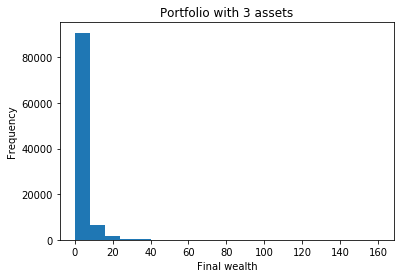

Average wealth for portfolio with 3 assets: 3.3693752
STD of wealth for portfolio with 3 assets: 5.0513544


In [33]:
plt.hist(y_pred[:,0],bins = 20)
plt.xlabel('Final wealth')
plt.ylabel('Frequency')
plt.title('Portfolio with ' +str(D) + ' assets')
plt.show()
print('Average wealth for portfolio with',D,'assets:',np.mean(y_pred[:,0]))
print('STD of wealth for portfolio with',D,'assets:',np.std(y_pred[:,0]))

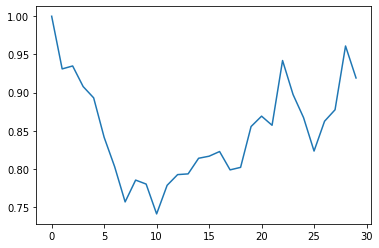

In [3]:
for i in range(1):
    plt.plot(S[:,i])
plt.show()

In [8]:
logX= np.zeros((N,R))
logX[0,]=np.log(X0)*np.ones((1,R))
alpha= (mu-r)/(sigma**2*(1-gamma))
for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
        logX[j+1,i] =logX[j,i]+increment*alpha+r*T/N*(1-alpha)-alpha**2*sigma**2*T/(2*N)

X=np.exp(logX)
loss=np.mean(-np.log(X[N-1,:]))# np.mean(-(W[N-1,:]**gamma))
print(loss)

-0.1214266866308976


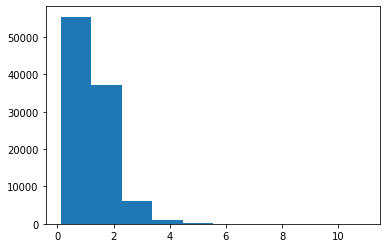

1.2731155502254579
0.6632545192723464


In [6]:
plt.hist(X[N-1,:])
plt.show()
print(np.mean(X[N-1,:]))
print(np.std(X[N-1,:]))

In [3]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards

N=30 # time disrectization
S0=1 # initial value of the asset
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
mu=0.1
r=0.0
gamma=0.0
R=10**5 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(mu*T/N-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

In [9]:
#Definition of neural networks for trading strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [10]:
# Implementing the outcoming of trading via neural networks
# Inputs is the training set below, containing the price S0, 
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
trade = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))

inputs = [price]+[trade]+[tradeeval]+[wealth]
outputhelper=[]

for j in range(N):
    strategy = price
    strategyeval=tradeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j 
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew
    logwealth= Lambda(lambda x : K.log(x))(wealth)
    logwealth= Lambda(lambda x : x+r*T/N)(logwealth)
    helper1 = Multiply()([strategy, incr])
    #helper1 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    logwealth = Add()([logwealth, helper1])
    helper2 = Multiply()([strategy, strategy])
    #helper2 = Lambda()(lambda x : K.sum(x,axis=1))([helper1])
    helper3 = Lambda(lambda x : x*sigma**2/2*T/N)(helper2)
    logwealth = Subtract()([logwealth, helper3])
    helper4 = Lambda(lambda x : x*r*T/N)(strategy)
    logwealth = Subtract()([logwealth, helper4])
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval] # here we collect the strategies
    wealth=wealthnew
outputs = wealth
randomendowment = Lambda(lambda x : -0.0*(K.abs(x-1.0)+x-1.0))(price) 
outputs = Add()([wealth,randomendowment])
outputs = [outputs] + outputhelper 
outputs = Concatenate()(outputs)

model_Merton = Model(inputs=inputs, outputs=outputs)

In [17]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0
# xtrain consists of the price S0, 
#the initial hedging being 0, and dummy variables hedgeeval where the strategies are evaluated, 
#the initial wealth and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,m))] +
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [18]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])#-((y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z

In [19]:
from keras import optimizers

adam=optimizers.Adam(lr=0.01)

model_Merton.compile(optimizer='adam',loss=custom_loss)

In [35]:
import matplotlib.pyplot as plt

for i in range(1):
    model_Merton.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
100000/100000 [==============================] - 25s 247us/step - loss: -0.1168
Epoch 2/10
100000/100000 [==============================] - 18s 180us/step - loss: -0.1218
Epoch 3/10
100000/100000 [==============================] - 20s 201us/step - loss: -0.1222
Epoch 4/10
100000/100000 [==============================] - 20s 199us/step - loss: -0.1226
Epoch 5/10
100000/100000 [==============================] - 17s 172us/step - loss: -0.1230
Epoch 6/10
100000/100000 [==============================] - 18s 180us/step - loss: -0.1231
Epoch 7/10
100000/100000 [==============================] - 19s 187us/step - loss: -0.1231
Epoch 8/10
100000/100000 [==============================] - 19s 195us/step - loss: -0.1232
Epoch 9/10
100000/100000 [==============================] - 19s 189us/step - loss: -0.1233
Epoch 10/10
100000/100000 [==============================] - 19s 187us/step - loss: -0.1234


In [36]:
y_pred = model_Merton.predict(xtrain)
print(np.mean(-np.log(y_pred[:,0])))

-0.123797126


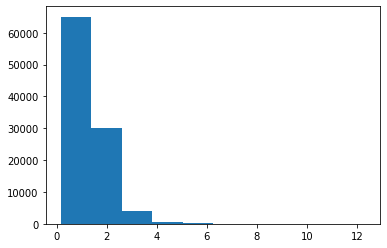

1.2842313
0.6885613


In [37]:
plt.hist(model_Merton.predict(xtrain)[:,0])
plt.show()
print(np.mean(model_Merton.predict(xtrain)[:,0]))
print(np.std(model_Merton.predict(xtrain)[:,0]))

In [50]:
#k=10#Choose a number between 1 and N-1
Ktest=60
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.7,1.5,Ktest)] +#change this if you go to higher dimensions
          [initialwealth*np.ones((Ktest,m))]+
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])


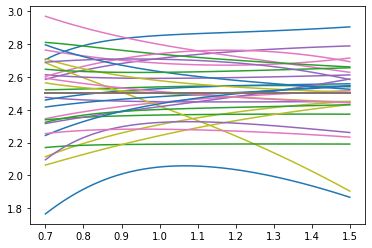

2.4999999999999996


In [49]:
#Comparison of learned and true alpha
s=np.linspace(0.7,1.5,Ktest)

for k in range(1,N):
    truestrat=(mu-r)/(sigma**2*(1-gamma))*np.ones(Ktest)
    learnedstrat=model_Merton.predict(xtest)[:,k]
    plt.plot(s,learnedstrat,s,truestrat)
plt.show()
print((mu-r)/(sigma**2*(1-gamma)))